#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project1 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/aivle/miniProject01/project2(miniProject01)/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩
    - pandas, numpy,matplotlib,seaborn, joblib 을 로딩하고
    필요한 라이브러리를 로딩합니다.
    <br>(분류 모델에서는 이번에 RandomForestClassifier를 씁니다. 더 많은 분류 모델을 써도 됩니다!)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns)
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [4]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [5]:
# 주어진 데이터 셋을 불러오세요.
train = pd.read_csv(path + 'data01_train.csv')
test = pd.read_csv(path + 'data01_test.csv')
features = pd.read_csv(path + 'features.csv')

In [6]:
#불필요한 칼럼을 삭제하세요.
train = train.drop(columns=['subject'])
test = test.drop(columns=['subject'])

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [7]:
# 전체 데이터의 행, 열 개수를 확인
print("train: ", train.shape)
print("test: ", test.shape)

train:  (5881, 562)
test:  (1471, 562)


In [8]:
# 전체 데이터의 상위 5개 행 확인
train.head(5)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [9]:
# 전체 데이터의 수치형 변수 분포 확인

#수치형 변수 추출
num_df = train.select_dtypes(include=['number'])

#기초 통계로 전체 파악
#정규화 여부: -1에서 1사이
#평균: 0 근처 -> 대부분 균형 잡힘
#결측치 없음
print("describe")
print(num_df.describe().T)

#전체 feature에 대한 히스토그램 > 데이터가 잘 안 보여서 별 의미 없음
# num_df.hist(figsize=(20, 20), bins=30)
plt.show()


describe
                                       count      mean       std       min  \
tBodyAcc-mean()-X                     5881.0  0.274811  0.067614 -0.503823   
tBodyAcc-mean()-Y                     5881.0 -0.017799  0.039422 -0.684893   
tBodyAcc-mean()-Z                     5881.0 -0.109396  0.058373 -1.000000   
tBodyAcc-std()-X                      5881.0 -0.603138  0.448807 -1.000000   
tBodyAcc-std()-Y                      5881.0 -0.509815  0.501815 -0.999844   
...                                      ...       ...       ...       ...   
angle(tBodyGyroMean,gravityMean)      5881.0  0.009340  0.608190 -1.000000   
angle(tBodyGyroJerkMean,gravityMean)  5881.0 -0.007099  0.476738 -1.000000   
angle(X,gravityMean)                  5881.0 -0.491501  0.509069 -1.000000   
angle(Y,gravityMean)                  5881.0  0.059299  0.297340 -1.000000   
angle(Z,gravityMean)                  5881.0 -0.054594  0.278479 -0.980143   

                                           25%       5

In [10]:
#전체 데이터의 모든 변수 확인
train.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다. (단변량: 하나의 변수를 단독 분석)
    - 범주별 빈도수, 종류, 비율, 시각화도 해보기!

In [12]:
# 범주 종류 수
n_classes = train['Activity'].nunique()
classes = train['Activity'].unique()

print("범주 개수:", n_classes)
print("범주 목록:", classes)

범주 개수: 6
범주 목록: ['STANDING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'
 'SITTING']


In [13]:
#Activity 빈도수, 비율 (train)
vc = train['Activity'].value_counts()                # 빈도수
vr = train['Activity'].value_counts(normalize=True)  # 비율

activity_univar = (
    pd.DataFrame({'Activity': vc.index, 'count': vc.values, 'ratio': vr.values})
    .sort_values('count', ascending=False)
    .reset_index(drop=True)
)

activity_univar['ratio'] = (activity_univar['ratio']*100).round(2)  # %
activity_univar


,Activity,count,ratio
0,LAYING,1115,18.96
1,STANDING,1087,18.48
2,SITTING,1032,17.55
3,WALKING,998,16.97
4,WALKING_UPSTAIRS,858,14.59
5,WALKING_DOWNSTAIRS,791,13.45


In [14]:
#Activity 빈도수, 비율 (test)
vc = test['Activity'].value_counts()                # 빈도수
vr = test['Activity'].value_counts(normalize=True)  # 비율

activity_univar = (
    pd.DataFrame({'Activity': vc.index, 'count': vc.values, 'ratio': vr.values})
    .sort_values('count', ascending=False)
    .reset_index(drop=True)
)

activity_univar['ratio'] = (activity_univar['ratio']*100).round(2)  # %
activity_univar

,Activity,count,ratio
0,LAYING,292,19.85
1,STANDING,287,19.51
2,SITTING,254,17.27
3,WALKING,228,15.50
4,WALKING_UPSTAIRS,215,14.62
5,WALKING_DOWNSTAIRS,195,13.26


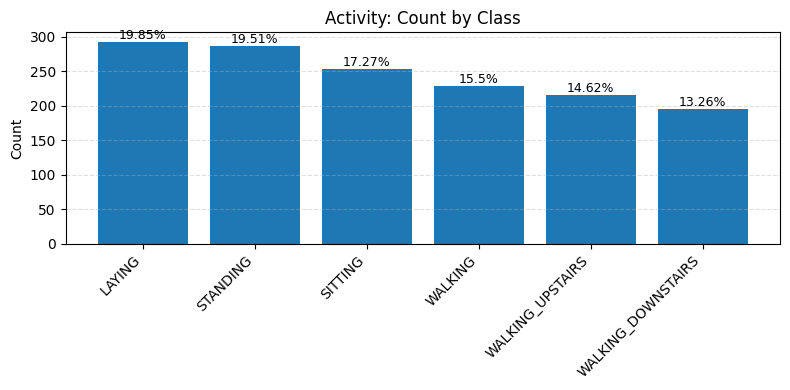

In [15]:
#시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
order = activity_univar['Activity']
plt.bar(order, activity_univar['count'])
plt.title('Activity: Count by Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# 막대 위에 비율(%) 표시
for x, c, r in zip(range(len(order)), activity_univar['count'], activity_univar['ratio']):
    plt.text(x, c, f'{r}%', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


In [16]:
# activity
#train, test 데이터 불균형 없음(분포 비슷)

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [17]:
#센서 그룹 데이터의 'sensor'변수의 값 확인
sensor_count = features['sensor'].value_counts()
print(sensor_count)

sensor
fBodyGyro               79
fBodyAccJerk            79
fBodyAcc                79
tBodyAcc                40
tGravityAcc             40
tBodyAccJerk            40
tBodyGyroJerk           40
tBodyGyro               40
tGravityAccMag          13
tBodyAccMag             13
tBodyGyroJerkMag        13
tBodyGyroMag            13
tBodyAccJerkMag         13
fBodyAccMag             13
fBodyBodyAccJerkMag     13
fBodyBodyGyroMag        13
fBodyBodyGyroJerkMag    13
angle                    7
Name: count, dtype: int64


In [18]:
#센서 그룹 데이터의 'agg'변수의 값 확인
sensor_count = features['agg'].value_counts()
print(sensor_count)

agg
bandsEnergy()        126
arCoeff()             60
std()                 33
mad()                 33
max()                 33
energy()              33
min()                 33
entropy()             33
iqr()                 33
mean()                33
sma()                 17
correlation()         15
kurtosis()            13
meanFreq()            13
skewness()            13
maxInds               13
arCoeff()4             5
arCoeff()2             5
arCoeff()3             5
arCoeff()1             5
tBodyAccMean           1
tBodyAccJerkMean       1
tBodyGyroMean          1
tBodyGyroJerkMean      1
X                      1
Y                      1
Z                      1
Name: count, dtype: int64


In [19]:
#센서 그룹 데이터의 'axis'변수의 값 확인
sensor_count = features['axis'].value_counts()
print(sensor_count)

axis
X              76
Y              76
Z              76
gravityMean     6
X,2             5
               ..
17,32.2         2
49,64.2         2
1,24.2          2
25,48.2         2
gravity         1
Name: count, Length: 62, dtype: int64


In [20]:
# #sensor 데이터 확인하는 이유
# 데이터 구조적 점검(어떤 물리적 의미를 가진 feature들로 구성되어 있는지)
# 편향 여부 점검(한쪽에 너무 몰려있지 않은지)

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [21]:
# 데이터 분할을 위한 전처리
from sklearn.model_selection import train_test_split

target = 'Activity'
x = train.drop(target, axis=1)
y = train[target]

x_train, x_valid, y_train, y_valid = train_test_split(
    x, y,
    test_size=0.2,
    stratify=y,       # 클래스 비율 유지(train, validation이 원래 y의 클래스 비율 그대로 나뉨)
    random_state=1 # 매번 같은 방식으로 섞어줌: 모델이 달라져도 test하는건 똑같아야해.
)

#### 2) 모델링

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#생성
rf_activity  = RandomForestClassifier(random_state=1)

#학습
rf_activity .fit(x_train, y_train)

#평가
y_pred = rf_activity .predict(x_valid)
accuracy_score(y_valid, y_pred)

print("Train Accuracy:", accuracy_score(y_train, rf_activity .predict(x_train)))
print("Validation Accuracy:", accuracy_score(y_valid, y_pred))

Train Accuracy: 1.0
Validation Accuracy: 0.9762107051826678


In [23]:
# #max_depth설정 x > 약한 과적합 있음
# Train Accuracy: 1.0
# Validation Accuracy: 0.973661852166525

#### 3) 변수 중요도 추출

,feature_name,feature_importance
0,"angle(X,gravityMean)",0.036874
1,tGravityAcc-min()-X,0.032805
2,tGravityAcc-energy()-X,0.031029
3,tGravityAcc-mean()-X,0.030705
4,tGravityAcc-min()-Y,0.026563


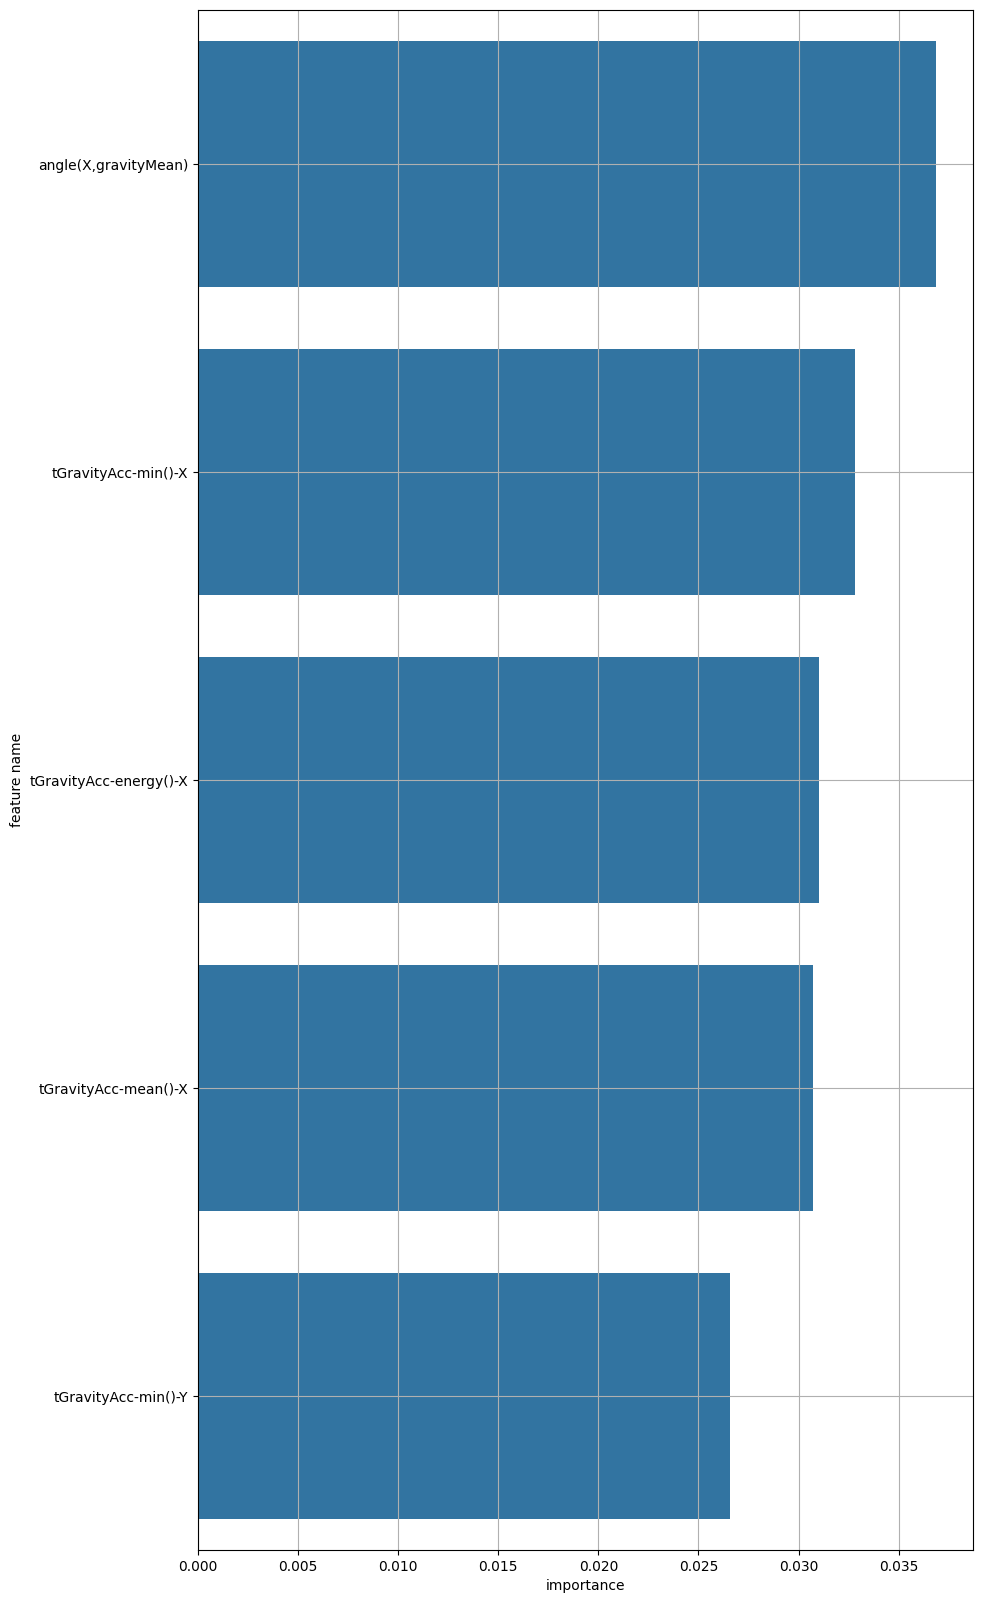

In [35]:
# 변수 중요도 추출(시각화로 나타내기)
# 변수 중요도 추출 및 시각화
fi_df = plot_feature_importance(
    importance = rf_activity .feature_importances_,   # 모델에서 추출한 중요도 값
    names = x_train.columns,                   # feature 이름들
    result_only = False,                       # 그래프도 함께 출력
    topn = 5                                  # 상위 30개만 시각화
)

# 중요도 상위 30개 feature 표 확인
fi_df.head(5)


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

    모델이 중요하다고 판단한 변수들이 실제로 target과 어떤 관계가 있는지 확인
  

#### 1) 상위 5, 하위 5개 변수 선정

In [25]:
# 중요도 상위 top 5
top5_features = fi_df['feature_name'].head(5).tolist()
print(top5_features)

['angle(X,gravityMean)', 'tGravityAcc-min()-X', 'tGravityAcc-energy()-X', 'tGravityAcc-mean()-X', 'tGravityAcc-min()-Y']


In [26]:
# 중요도 하위 top 5
bottom5_features = fi_df['feature_name'].tail(5).tolist()
print(bottom5_features)

['tBodyAccJerkMag-entropy()', 'fBodyAccJerk-bandsEnergy()-1,24', 'tBodyAccJerk-entropy()-Y', 'tGravityAcc-arCoeff()-Z,4', 'tBodyAccJerk-std()-X']


#### 2) 상위 5개 변수에 대한 분석
        - 위에서 나온 상위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

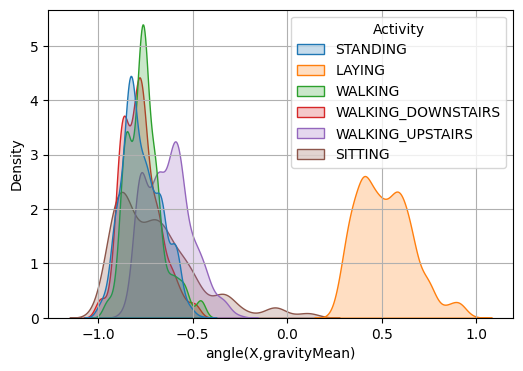

In [36]:
#1위 : angle(Y,gravityMean)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.kdeplot(
    data=train,
    x='angle(X,gravityMean)',   # x축: 우리가 분석할 feature
    hue='Activity',             # 색으로 구분할 target 변수
    fill=True,                  # 아래 영역 채우기 (부드럽게)
    common_norm=False           # 클래스별 분포 보려고
)

plt.grid(True)
plt.show()


In [28]:
#angle(Y,gravityMean): 누워있기를 다른 행동과 구분하는데 도움을 주는 변수.

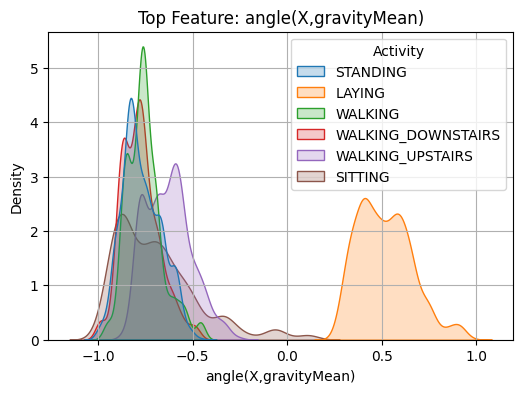

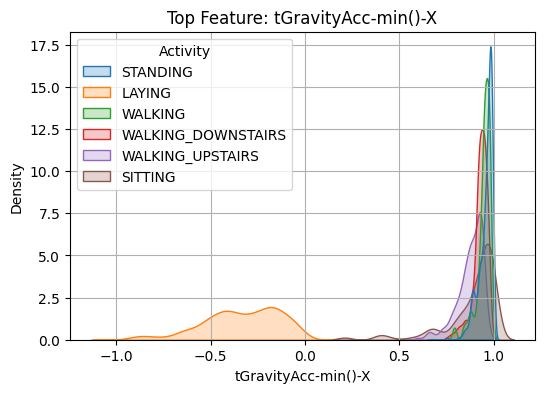

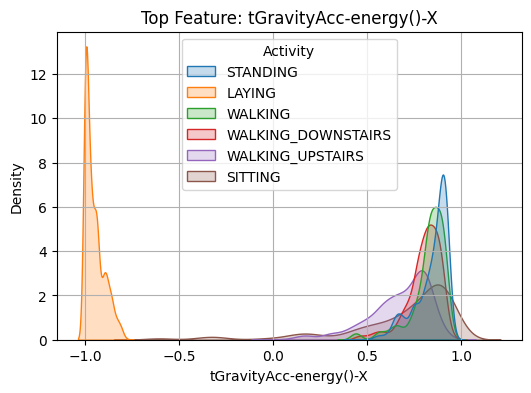

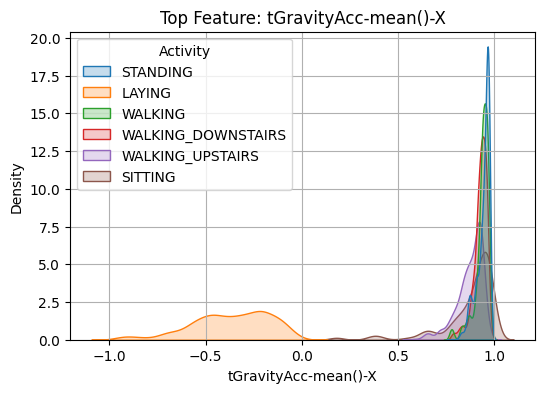

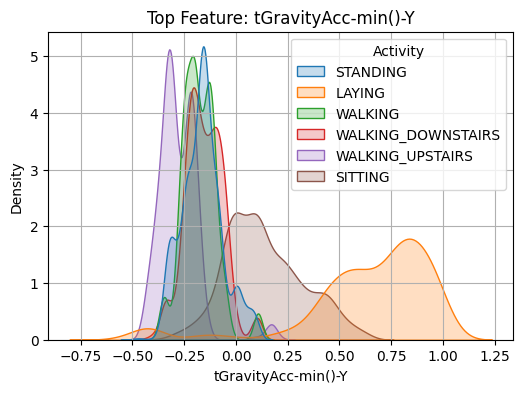

In [29]:
#상위 그래프
for f in top5_features:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=train, x=f, hue='Activity', fill=True, common_norm=False)
    plt.title(f'Top Feature: {f}')
    plt.xlabel(f)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

In [30]:
#상위 5개 변수가 누워있기에만 특화된 feature 같아 보였음. (예상 원인: 다 중력 관련 변수들이라)
# 가설: train, val을 바꿔도 성능이 유지됨 > 데이터가 고르게 분포되어있음

In [31]:
#데이터 확인1
#교차검증(k-fold cross validation)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(RandomForestClassifier(random_state=1),
                         x_train, y_train, cv=cv, scoring='accuracy')
print("CV 정확도:", scores)
print("평균:", np.mean(scores))

CV 정확도: [0.97130712 0.96918172 0.97874601 0.97662062 0.97340426]
평균: 0.9738519456440635


In [32]:
#결과: 점수들이 일정하게 유지되는 편>데이터가 안정적으로 target 구분 가능

In [33]:
#데이터 확인2
#혼동행렬

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = fi_activity .predict(x_valid)
cm = confusion_matrix(y_valid, y_pred, labels=fi_activity.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fi_activity.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Validation Set")
plt.show()

NameError: name 'fi_activity' is not defined

In [ ]:
#결과
#누워있기, 걷기는 매우 잘 구분
#앉기, 서있기를 혼동함
#(스마트폰 센서 데이터 한계, 앉기와 서 있을 때 가속도, 자이로 값이 거의 같음 )

#데이터는 잘 구분된다.

#### 3) 하위 5개 변수에 대한 분석
        - 위에서 하위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

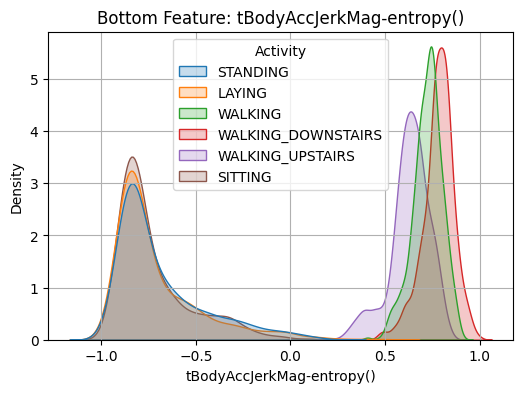

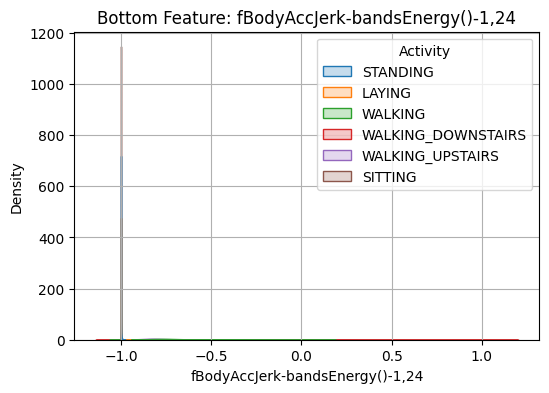

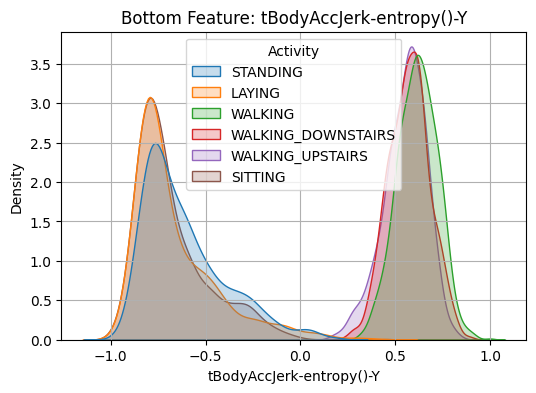

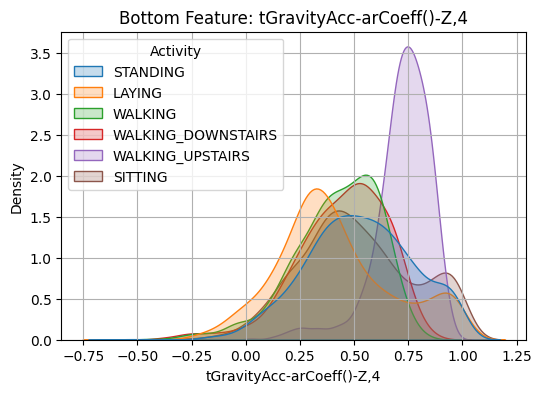

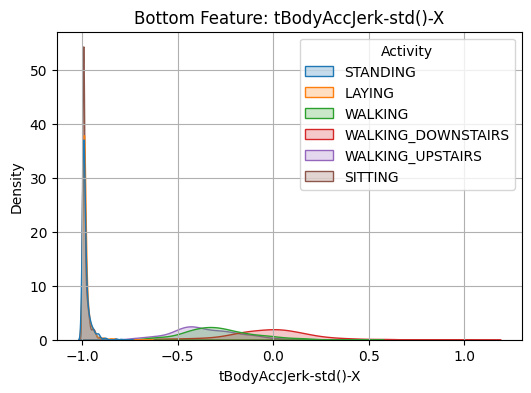

In [37]:
#하위 5개 그래프
for f in bottom5_features:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=train, x=f, hue='Activity', fill=True, common_norm=False)
    plt.title(f'Bottom Feature: {f}')
    plt.xlabel(f)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

In [ ]:
#하위 5개: 구분에 큰 의미 없음을 파악함

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.


#### 1) is_dynamic 추가

In [ ]:
#is dynamic 변수를 추가하세요(값 0, 값 1 확인해서!)

# 정적 / 동적 행동 분류 기준 설정
static_actions = ['STANDING', 'SITTING', 'LAYING']
dynamic_actions = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']

# is_dynamic 변수 추가
train['is_dynamic'] = train['Activity'].apply(lambda x: 1 if x in dynamic_actions else 0)

# 값 분포 확인
train['is_dynamic'].value_counts()


#### 2) 기본모델 생성

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
X = train.drop(columns=['Activity', 'is_dynamic'])
y = train['is_dynamic']

# 데이터 분할
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y  #클래스 비율 유지(train, validation이 원래 y의 클래스 비율 그대로 나뉨)
)

#확인
x_train2.shape, x_valid2.shape


In [ ]:
#RandomForestClassifier로 모델링 진행
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_isdynamic = RandomForestClassifier(random_state=42)

rf_isdynamic.fit(x_train2, y_train2)

y_pred2 = rf_isdynamic.predict(x_valid2)

acc = accuracy_score(y_valid2, y_pred2)
print(f"Validation Accuracy: {acc:.4f}")

In [ ]:
#결과: 동적,정적 구분은 거의 완벽하게 됨.

#### 3) 변수중요도 상위 5개 분석

In [ ]:
# is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석!

fi_isdynamic = plot_feature_importance(
    rf_isdynamic.feature_importances_,     # 중요도 값
    x_train2.columns,                      # feature 이름
    result_only=False,                     # 그래프 + 데이터프레임 둘 다
    topn=5                              # 상위 10개만 보기 (원하면 5로 변경)
)

# 상위 5개만 따로 출력
fi_isdynamic.head(5)


* 미션1에서 했던 것 처럼 상위 5개의 변수 데이터를 탐색해보기!

In [ ]:
top5_isdynamic = fi_isdynamic['feature_name'].head(5).tolist()

# 시각화
for f in top5_isdynamic:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=train, x=f, hue='is_dynamic', fill=True, common_norm=False)
    plt.title(f'Feature: {f}')
    plt.xlabel(f)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()


In [ ]:
#상위 5개: 구분 잘 함

In [ ]:
# 하위 5개
bo5_isdynamic = fi_isdynamic['feature_name'].tail(5).tolist()

# 시각화
for f in bo5_isdynamic:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=train, x=f, hue='is_dynamic', fill=True, common_norm=False)
    plt.title(f'Feature: {f}')
    plt.xlabel(f)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()


## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

In [ ]:
#모델을 만들 때 다 model로 만들어서 모델별 중요도를 읽어올 수 없다.
#모델명을 model말고 rf_isdynamic처럼 구분 가능한 이름으로 짓기

In [ ]:
# tip : rename을 써서 칼럼 이름 수정을 해야합니다!
#두 모델에서 중요도 DataFrame 생성
fi_activity = plot_feature_importance(
    rf_activity.feature_importances_,
    x_train.columns,
    result_only=True
)
fi_isdynamic = plot_feature_importance(
    rf_isdynamic.feature_importances_,
    x_train2.columns,
    result_only=True
)

# 2) 칼럼명 구분해서 변경
fi_activity = fi_activity.rename(columns={'feature_importance': 'importance_activity'})
fi_isdynamic = fi_isdynamic.rename(columns={'feature_importance': 'importance_isdynamic'})



#### 2) 합치기

In [ ]:
# merge 해서 2개를 합치는 작업하기.
fi_merged = pd.merge(
    fi_activity[['feature_name', 'importance_activity']],
    fi_isdynamic[['feature_name', 'importance_isdynamic']],
    on='feature_name',
    how='outer'              # 한쪽에만 있는 feature도 포함
)

# 중요도와 features 합치기
fi_merged_full = pd.merge(
    fi_merged,
    features,                # feature_name, sensor, agg, axis
    on='feature_name',
    how='left'
)

In [ ]:
#확인
# 행/열 개수 확인
print(fi_merged_full.shape)

# 컬럼명 확인
print(fi_merged_full.columns.tolist())

### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
# joblib.dump 이용해서 colab에 .pkl 파일에 저장하기(tip: path + '파일 이름.pkl')

import joblib
joblib.dump(fi_merged_full, path + 'feature_importance.pkl')

In [ ]:
#확인
import os
os.listdir(path)